In [ ]:
import torch
torch.cuda.empty_cache()

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization")

In [ ]:
!pwd

/content


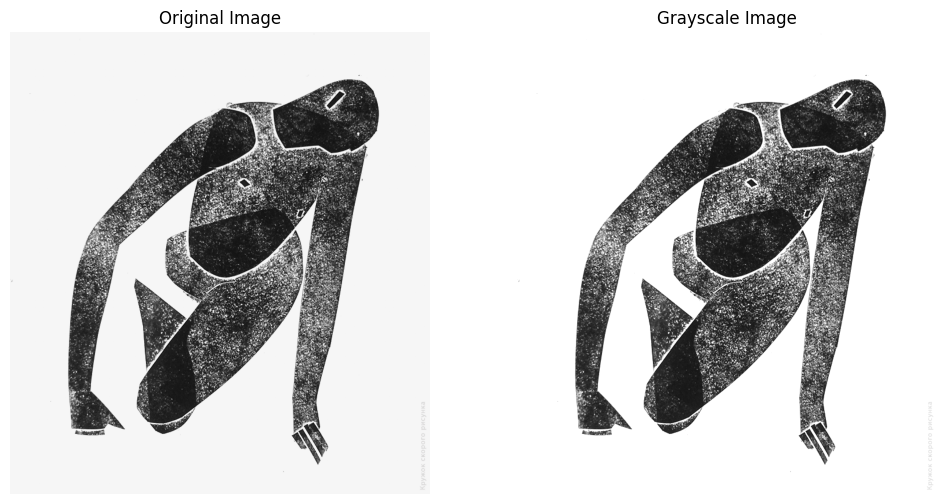

In [3]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'./dataset/training_set'  # Update this path
output_directory_base = r'./dataset/gray_training_set'  # Update this path

# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [4]:
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms

training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_training_set',
    color_dir=r'./dataset/training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_validation_set',
    color_dir=r'./dataset/validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)

In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform: PyTorch transforms for transforms and tensor conversion.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform)
        self.color_dataset = ImageFolder(color_dir, transform=transform)
        self.transform = transform

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [8]:
for inputs, _ in DataLoader(training_data, batch_size=1, shuffle=True):
    print(f"Grayscale image size: {inputs.size()}")
    break  # Print the size of the first batch only to check the dimensions.

Grayscale image size: torch.Size([1, 1, 256, 256])


In [9]:
import torch
import torch.nn as nn

class ModifiedBottleneck(nn.Module):
    expansion = 2  # Lowered from the original 4 to reduce complexity

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ModifiedBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ColorizationResNet(nn.Module):
    def __init__(self):
        super(ColorizationResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet layers with modified bottleneck
        self.layer1 = self._make_layer(ModifiedBottleneck, 64, 3, stride=1)
        self.layer2 = self._make_layer(ModifiedBottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(ModifiedBottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(ModifiedBottleneck, 512, 3, stride=2)

        # Upsampling layers
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.final_activation = nn.Tanh()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.upsample_layers(x)
        x = self.final_conv(x)
        x = self.final_activation(x)
        x = (x + 1) / 2  # Normalize output to [0, 1]
        return x


In [10]:
RESNET_model = ColorizationResNet()
model_path = r'./model/artifact/resnet_loss=Smoothl1_batch16_lr=0.0001_on75_&lr=0.00001on20/model_state_dict.pth'
load_pth = True
if load_pth:
    checkpoint = torch.load(model_path)
    RESNET_model.load_state_dict(checkpoint)

In [11]:
RESNET_model = RESNET_model.cuda()

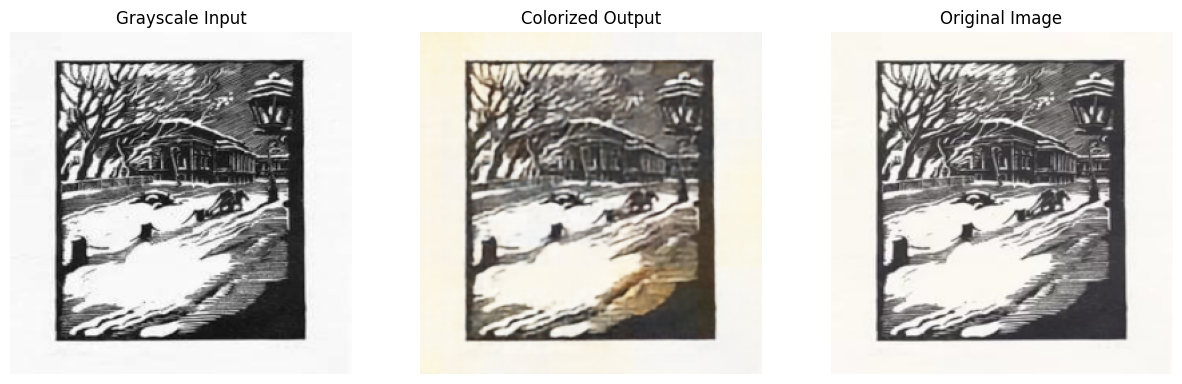

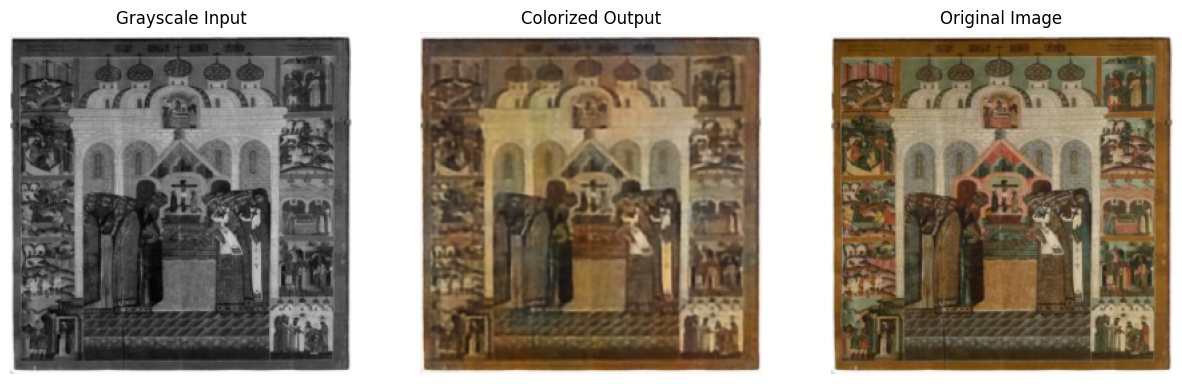

In [ ]:
def visualize_results(grayscale, colorized, original):
    """
    Visualize grayscale input, colorized output, and the original color image.
    """
    with torch.no_grad():
        # Convert to numpy arrays
        grayscale = grayscale.cpu().numpy().transpose((1, 2, 0))
        colorized = colorized.cpu().numpy().transpose((1, 2, 0))
        original = original.cpu().numpy().transpose((1, 2, 0))

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(grayscale, cmap='gray')
        ax[0].set_title("Grayscale Input")
        ax[0].axis("off")

        ax[1].imshow(colorized)
        ax[1].set_title("Colorized Output")
        ax[1].axis("off")

        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis("off")

        plt.show()

# Assuming `model`, `validation_loader` are already defined and ready to use
RESNET_model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = RESNET_model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[1], colorized_outputs[1], original_colors[1])
    visualize_results(grayscale_inputs[10], colorized_outputs[10], original_colors[10])

Evaluations

In [12]:
import torch
import numpy as np
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(image_true, image_test):
    mse = F.mse_loss(image_true, image_test)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

def calculate_mse(image_true, image_test):
    return F.mse_loss(image_true, image_test).item()

def calculate_ssim(image_true, image_test, data_range=1.0, win_size=7):
    # Convert tensors to numpy arrays
    image_true_np = image_true.squeeze().cpu().numpy().transpose((1, 2, 0))
    image_test_np = image_test.squeeze().cpu().numpy().transpose((1, 2, 0))

    # Ensure the window size is odd and smaller than the image dimensions
    win_size = min(win_size, min(image_true_np.shape[:2])-1)
    if win_size % 2 == 0:  # Make the window size odd
        win_size -= 1

    # Calculate SSIM
    ssim_value = ssim(image_true_np, image_test_np, data_range=data_range, multichannel=True, win_size=win_size)
    return ssim_value

In [13]:
def calculate_evaluations(model, validation_loader):
    total_psnr = []
    total_mse = []
    total_ssim = []

    model.eval()
    for grayscale_inputs, original_colors in validation_loader:
        grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

        with torch.no_grad():
            colorized_images = model(grayscale_inputs)

        for colorized, original in zip(colorized_images, original_colors):
            total_psnr.append(calculate_psnr(original.unsqueeze(0), colorized.unsqueeze(0)))
            total_mse.append(calculate_mse(original.unsqueeze(0), colorized.unsqueeze(0)))
            total_ssim.append(calculate_ssim(original.unsqueeze(0), colorized.unsqueeze(0), win_size=3))
    mean_psnr = np.mean(total_psnr)
    mean_mse = np.mean(total_mse)
    mean_ssim = np.mean(total_ssim)
    return mean_psnr, mean_mse, mean_ssim

In [14]:
mean_psnr, mean_mse, mean_ssim = calculate_evaluations(RESNET_model, validation_loader)
print(f"Mean PSNR: {mean_psnr:.2f}, Mean MSE: {mean_mse:.4f}, Mean SSIM: {mean_ssim:.4f}")

<ipython-input-12-402a1c129d5a>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image_true_np, image_test_np, data_range=data_range, multichannel=True, win_size=win_size)


Mean PSNR: 25.89, Mean MSE: 0.0049, Mean SSIM: 0.8325


AUC

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import cv2

def compute_l2_distance(predicted, ground_truth):
    # Calculate L2 distance in ab color space
    l2_distance = torch.sqrt(torch.sum((predicted - ground_truth) ** 2, dim=1))
    return l2_distance

def compute_proportions(l2_distances, thresholds):
    # Calculate the proportion of pixels below each threshold
    proportions = [(l2_distances < t).float().mean().item() for t in thresholds]
    return proportions


def rgb_to_lab(rgb_images):
    lab_images = []
    for img in rgb_images:
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert from PyTorch tensor to NumPy array
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)  # Convert from RGB to Lab
        lab_images.append(torch.tensor(img_np).permute(2, 0, 1))  # Convert back to PyTorch tensor
    return torch.stack(lab_images)  # Stack all tensor images into a single tensor

# Define your thresholds for L2 distance
thresholds = np.linspace(0, 100, num=100)  # Example thresholds

# Initialize an empty list to store L2 distances for all images
all_l2_distances = []

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = RESNET_model(grayscale_inputs)


    # Convert colorized and original images from RGB to Lab
    colorized_images_lab = rgb_to_lab(colorized_images)
    original_colors_lab = rgb_to_lab(original_colors)

    # extract the 'a' and 'b' channels
    predicted_ab = colorized_images_lab[:, 1:, :, :]
    ground_truth_ab = original_colors_lab[:, 1:, :, :]


    l2_distances = compute_l2_distance(predicted_ab, ground_truth_ab)
    all_l2_distances.append(l2_distances)

# Concatenate all L2 distances
all_l2_distances = torch.cat(all_l2_distances, dim=0)

# Compute proportions for each threshold
proportions = compute_proportions(all_l2_distances, thresholds)

# Compute the Area under Curve (AuC) for plotting
auc_value = auc(thresholds, proportions)
print(f"AuC: {auc_value:.4f}")

AuC: 89.2314


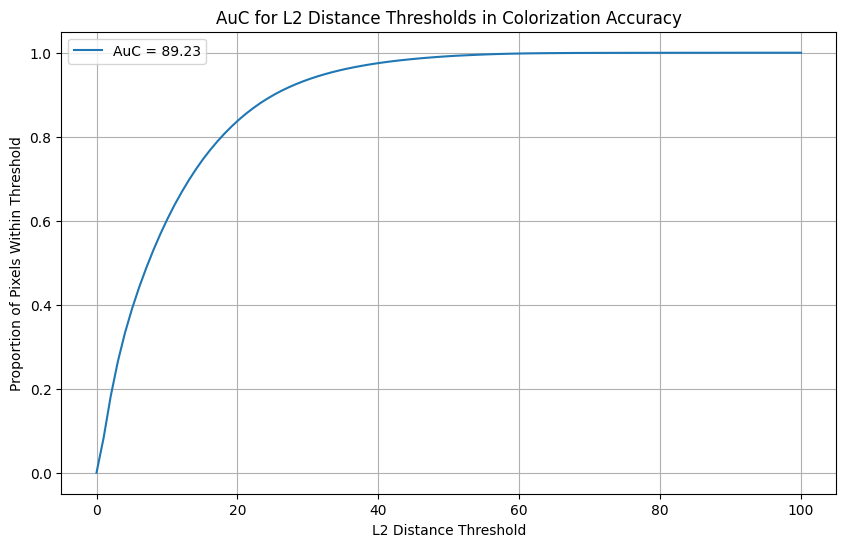

In [ ]:
# Plotting the AuC curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, proportions, label=f'AuC = {auc_value:.2f}')
plt.title('AuC for L2 Distance Thresholds in Colorization Accuracy')
plt.xlabel('L2 Distance Threshold')
plt.ylabel('Proportion of Pixels Within Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torchvision.models as models
import torchvision.transforms as transforms

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True).cuda()
vgg.eval()

# Define a transform to prepare the images for VGG
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 images
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for VGG
])

correct = 0
total = 0
colorized_preds_all = []
original_preds_all = []

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = RESNET_model(grayscale_inputs)

    # Apply the necessary transforms
    colorized_images_vgg = transform(colorized_images)
    original_colors_vgg = transform(original_colors)

    # Get predictions from VGG
    colorized_preds = vgg(colorized_images_vgg).argmax(dim=1)
    original_preds = vgg(original_colors_vgg).argmax(dim=1)

    # Compare predictions
    colorized_preds_all += colorized_preds
    original_preds_all += original_preds
    correct += (colorized_preds == original_preds).sum().item()
    total += original_colors.size(0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]


In [15]:
import torchvision.models as models
import torchvision.transforms as transforms

vgg = models.vgg16(pretrained=True).cuda()
vgg.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizes the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizes the image
])

correct = 0
total = 0

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = RESNET_model(grayscale_inputs)

    colorized_images_vgg = [preprocess(img).unsqueeze(0) for img in colorized_images]
    original_images_vgg = [preprocess(img).unsqueeze(0) for img in original_colors]

    for colorized_img, original_img in zip(colorized_images_vgg, original_images_vgg):
        colorized_pred = vgg(colorized_img.cuda()).argmax(dim=1)
        original_pred = vgg(original_img.cuda()).argmax(dim=1)

        correct += int(colorized_pred == original_pred)
        total += 1

accuracy = correct / total
print(f"Semantic Interpretability Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 113MB/s]


Semantic Interpretability Accuracy: 0.4393


In [16]:
# Calculate the accuracy
accuracy = correct / total
print(f"Semantic Interpretability Accuracy: {accuracy:.4f}, where correct = {correct} and total = {total}")

Semantic Interpretability Accuracy: 0.4393, where correct = 376 and total = 856
